In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from time import time
from datetime import datetime, timedelta

In [3]:
pd.read_csv('catfish.csv').head(13)

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239
5,1986-6-01,8951
6,1986-7-01,9668
7,1986-8-01,10188
8,1986-9-01,9896
9,1986-10-01,10649


In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [6]:
df = pd.read_csv('catfish.csv', date_parser = parser, parse_dates = [0], index_col = 0)

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_53870/1938713234.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('catfish.csv', date_parser = parser, parse_dates = [0], index_col = 0)


In [7]:
# this step is helpful for time series data to measure the frequency of an irregular data
df = df.asfreq(pd.infer_freq(df.index))

In [16]:
new_df = df.loc['2000-01-01': '2004-01-01']

In [20]:
new_df.mean()[0]

25667.020408163266

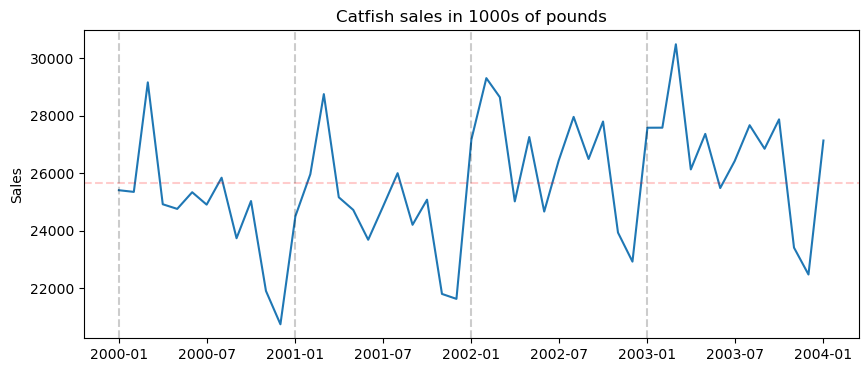

In [23]:
plt.figure(figsize=(10,4))
plt.plot(new_df)
plt.title('Catfish sales in 1000s of pounds')
plt.ylabel('Sales')

plt.axhline(new_df.mean()[0], color = 'r', linestyle = '--', alpha = 0.2)

for year in range(2000, 2004):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

### NOTE
We see that the trend in the first two year goes down (mean below the red line) whereas in the later two years goes up, so mean above the red line, which shows the mean is not constant. Hence data is not stationary. 

We can start by looking at the first difference 

In [40]:
first_diff_df = new_df.diff()
# i am dropping the first value instead of setting it to zero 
first_diff_df = first_diff_df.dropna()

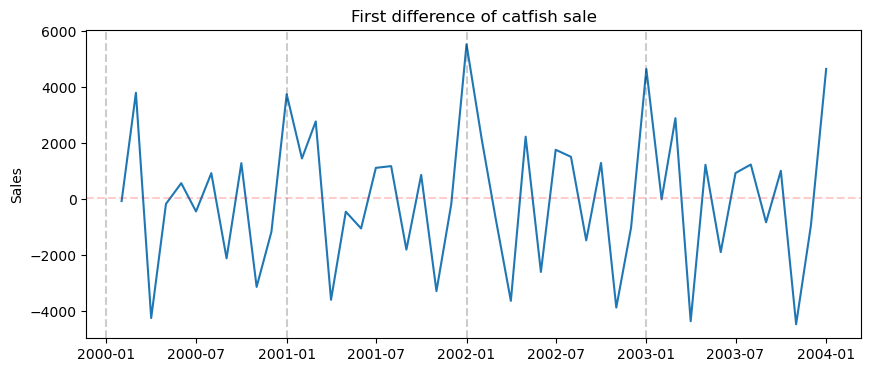

In [41]:
plt.figure(figsize=(10,4))
plt.plot(first_diff_df)
plt.title('First difference of catfish sale')
plt.ylabel('Sales')

plt.axhline(first_diff_df.mean()[0], color = 'r', linestyle = '--', alpha = 0.2)

for year in range(2000, 2004):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

### NOTE:
Here the mean yearwise looks like much more constant

Now looking at ACF and PACF, to figure out the order of MA and AR respectively

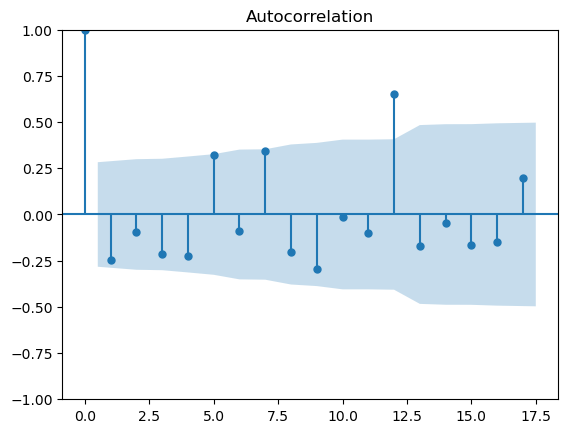

In [42]:
acf_plot = plot_acf(first_diff_df)

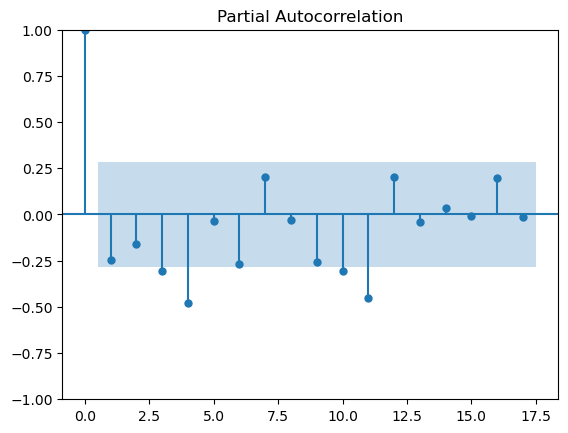

In [43]:
pacf_plot = plot_pacf(first_diff_df)

**Based on above ACF and PACF plot, we see that at lag 0 is correlation is max (as expected). For ACF, lag 1 seems to be a good first choice, for PACF, lag 4 seems to be a good choice. We see a large PACF at lag 12 which implies seasonality, that we will explore using SARIMA model, later on**

**So, we are using MA(1) and AR(4), based on plots**

## Get training and testing data

In [44]:
train_end = datetime(2003, 7, 1)
test_end = datetime(2004, 1, 1) 

train_df = first_diff_df[:train_end]
test_df = first_diff_df[train_end + timedelta(days = 1) : test_end]

## Fit the ARMA model using ARIMA(4,1)

In [45]:
model = ARIMA(train_df, order = (4, 0, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Sat, 03 Aug 2024   AIC                            767.195
Time:                        12:12:41   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.846
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.085      -0.905       0.058
ar.L3         -0.5574      0.302     -1.844      0.065      -1.150       0.035
ar.L4         -0.6121      0.177     -3.449      0.001      -0.960      -0.264
ma.L1          0.5190      0.267      1.945      0.052      -0.004       1.042
sigma2      3.529e+06   9.89e+05      3.568      0.000    1.59e+06    5.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.65   Prob(JB):                         0.49
Heteroskedasticity (H):               0.99   Skew:                             0.39
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## NOTE:
- In the coef column, we see that all the AR coefficients are negative, and MA coefficient is positive.
- In the p-value column, we see that all the AR and MA values are les than 0.5, but constant term > 0.5, so we will drop the constant term from our model

Predicted model will look like 

$\hat{y_t} =  -0.87 y_{t-1} - 0.42 y_{t-2} - 0.56 y_{t-3} - 0.61 y_{t-4} + 0.52 \epsilon_{t-1} $ 

In [47]:
predictions = model_fit.predict(start = test_df.index[0], end = test_df.index[-1])

In [48]:
predictions

2003-08-01    2138.432870
2003-09-01   -1872.433917
2003-10-01    1428.195249
2003-11-01   -2127.703489
2003-12-01    1056.169106
2004-01-01     419.991979
Freq: MS, Name: predicted_mean, dtype: float64

In [63]:
model_fit.predict('2003-08-01')[0]

2138.432869598522

Text(0, 0.5, 'Sales')

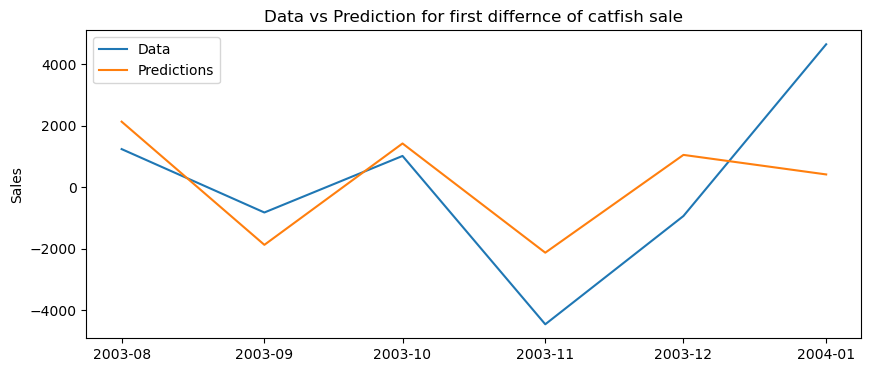

In [50]:
plt.figure(figsize=(10,4))
plt.plot(test_df)
plt.plot(predictions)
plt.title('Data vs Prediction for first differnce of catfish sale')
plt.legend(['Data', 'Predictions'])
plt.ylabel('Sales')


In [54]:
print('RMSE error:' , np.sqrt(np.mean((predictions - test_df['Total'])**2)))

RMSE error: 2214.6996924903383


#### We see the predicted model captures the shape, but the values are not close. So model needs further modification